# Cody Nichols' COMP 6970 Final Project
This will be where I test and compile my final results from my findings.

- Paper 1
    - ~~Read Paper~~
    - ~~Implement Bullish/Bearish Classification with NN Structure~~
    - ~~Implement Candlestick Classification with NN Structure~~
- Paper 2
    - ~~Read Paper~~
    - ~~Implement MS-CNN Architecture~~
    - ~~Create DDQN Architecture~~
- ~~Paper 3 (Time Permitting) (Decided Not To Do After Finishing Paper 2 Because of Complexity of Paper 2)~~
- Complete Project
    - Combine Code (in this ipynb)
        - ~~Implement Dataset Curation~~
        - ~~Create my own version of Paper 1 (Never did this (Paper 1's output was deemed irrelevant in overall goal))~~
        - ~~Create my own version of Paper 2 (Modified the MS-CNN to accept advanced, labeled input)~~
        - ~~Combine the outputs of Paper 1 and 2's vision components as inputs for Paper 2's DDQN (Both papers were combined into this document, but only Paper 2's impelementation  was modified)~~
    - Write Paper
    - Create Presentation
    - Make Recording

# Paper 1 Rendition
Paper 1 (Empowering Financial Technical Analysis Using Computer Vision Techniques) creates a CNN architecture that classifies candlestick charts in 2 ways. The first classification is a binary classification of bullish or bearish for a 20-candlestick image. The second classification is a multi-class classification of candlestick pattern type based on each individual candlestick and some surrounding candlesticks. The CNN architecture is 14-layer CNN with a 8 convolution layers, 3 max pooling layers, a VGG-16 pretrained preprocessing layer, a fully connected layer, and an output layer. This architecture was implemented in paper1.ipynb for the binary classification task, but was not used for the multi-class classification task. The reasoning behind not using it for the multi-class classification task was because of the ambiguity on how the model was trained. The assumed training method was dividing up the candlestick charts into smaller images to make classification on each candlestick and labeling each image easier, but there were some issues with the images I created not being big enough to make it all the way through without needing to size them back up. 

In this notebook, I will perform the same classification tasks with the knowledge that I have gained from implementing the author's solution to achieve the best accuracy on the binary classification and the best per-class accuracy for the multi-class classifcation. This per-class accuracy is because I will be having "None" labels in my candlesticks (unlike the author of Paper 1) because most candlesticks in candlestick charts do not have a pattern.

# Important Note:

When running the GAF Implementation or the Regular Implementation, make sure you do not run all sections of code. For a GAF run, run just the GAF sections. For a Regular run, run just the regular sections.

In [19]:
# Imports

import os
import cv2
import math
import torch
import random
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import random_split, DataLoader, Dataset
from PIL import Image
from pyts.image import GramianAngularField
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from torchvision.transforms import ToTensor
from torch.utils.data import Subset
from sklearn.preprocessing import StandardScaler

symbol = 'AAPL'

In [20]:
# Device Checking

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device being used:", device)

PyTorch version: 2.5.1+cu118
CUDA available: True
CUDA version: 11.8
Number of GPUs: 1
GPU 0: NVIDIA GeForce GTX 1660 Ti
Device being used: cuda


# Without GAF

In [15]:
'''
Candlestick Dataset without Gramian Angular Fields.
'''

class StockCandlestickDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith(".png")
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        label = 1 if "Bullish" in img_path else 0

        return image, label

# With GAF

In [21]:
'''
Candlestick Dataset with Gramian Angular Fields applied.
'''

class StockCandlestickDatasetWithGAF(Dataset):
    def __init__(self, data_dir, transform=None, gaf_image_size=224):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith(".png")
        ]
        self.gaf_transformer = GramianAngularField(image_size=gaf_image_size, method='summation')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        image = Image.open(img_path).convert('L')
        image_array = np.array(image)
        
        gaf_image = self.gaf_transformer.fit_transform(image_array.reshape(1, -1))[0]
       
        gaf_image = Image.fromarray((gaf_image * 255).astype(np.uint8)).convert("RGB")
        
        if self.transform:
            gaf_image = self.transform(gaf_image)
        
        label = 1 if "Bullish" in img_path else 0

        return gaf_image, label

# Regular Dataset

In [16]:
'''
Actual dataset initialized with the non-GAF dataset class.
'''

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = f'./labeling/20_minute_intervals'

dataset = StockCandlestickDataset(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# GAF Dataset

In [22]:
'''
Actual dataset initialized with the GAF dataset class.
'''

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = f'./labeling/20_minute_intervals'

dataset = StockCandlestickDatasetWithGAF(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Begin Shared Code

In [23]:
'''
CNN according to paper's specifications.
'''

class CandlestickClassifier(nn.Module):
    def __init__(self):
        super(CandlestickClassifier, self).__init__()
        
        self.vgg_base = models.vgg16().features
        for param in self.vgg_base.parameters():
            param.requires_grad = False
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(512, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.vgg_base(x)
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

Epoch [1/20], Loss: 0.6936
Epoch [2/20], Loss: 0.6922
Epoch [3/20], Loss: 0.6909
Epoch [4/20], Loss: 0.6894
Epoch [5/20], Loss: 0.6880
Epoch [6/20], Loss: 0.6867
Epoch [7/20], Loss: 0.6862
Epoch [8/20], Loss: 0.6856
Epoch [9/20], Loss: 0.6854
Epoch [10/20], Loss: 0.6852
Epoch [11/20], Loss: 0.6849
Epoch [12/20], Loss: 0.6852
Epoch [13/20], Loss: 0.6860
Epoch [14/20], Loss: 0.6845
Epoch [15/20], Loss: 0.6840
Epoch [16/20], Loss: 0.6838
Epoch [17/20], Loss: 0.6832
Epoch [18/20], Loss: 0.6830
Epoch [19/20], Loss: 0.6814
Epoch [20/20], Loss: 0.6786


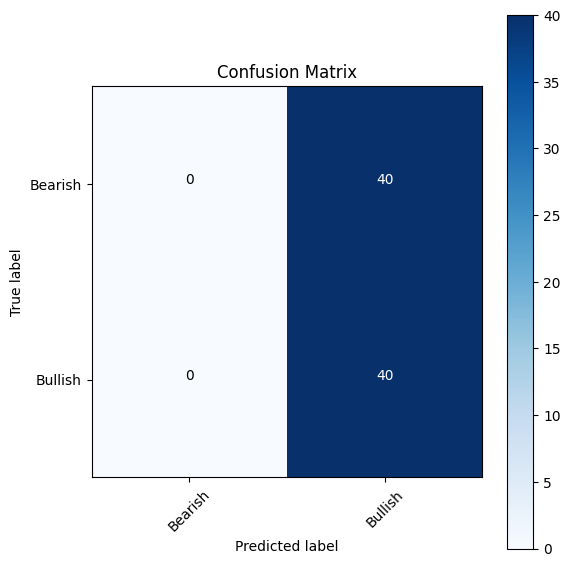

Test Accuracy: 50.00%


In [24]:
'''
Training Loop dependent upon what cells you decide to run above. Running the cells without GAF will yield better results.
Results are commented on below
'''

num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CandlestickClassifier().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels).flatten()
all_predictions = np.array(all_predictions).flatten()

conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()

classes = ["Bearish", "Bullish"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.0
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

accuracy = np.sum(all_predictions == all_labels) / len(all_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Begin Implementation of Individual Candlestick Pattern Detection

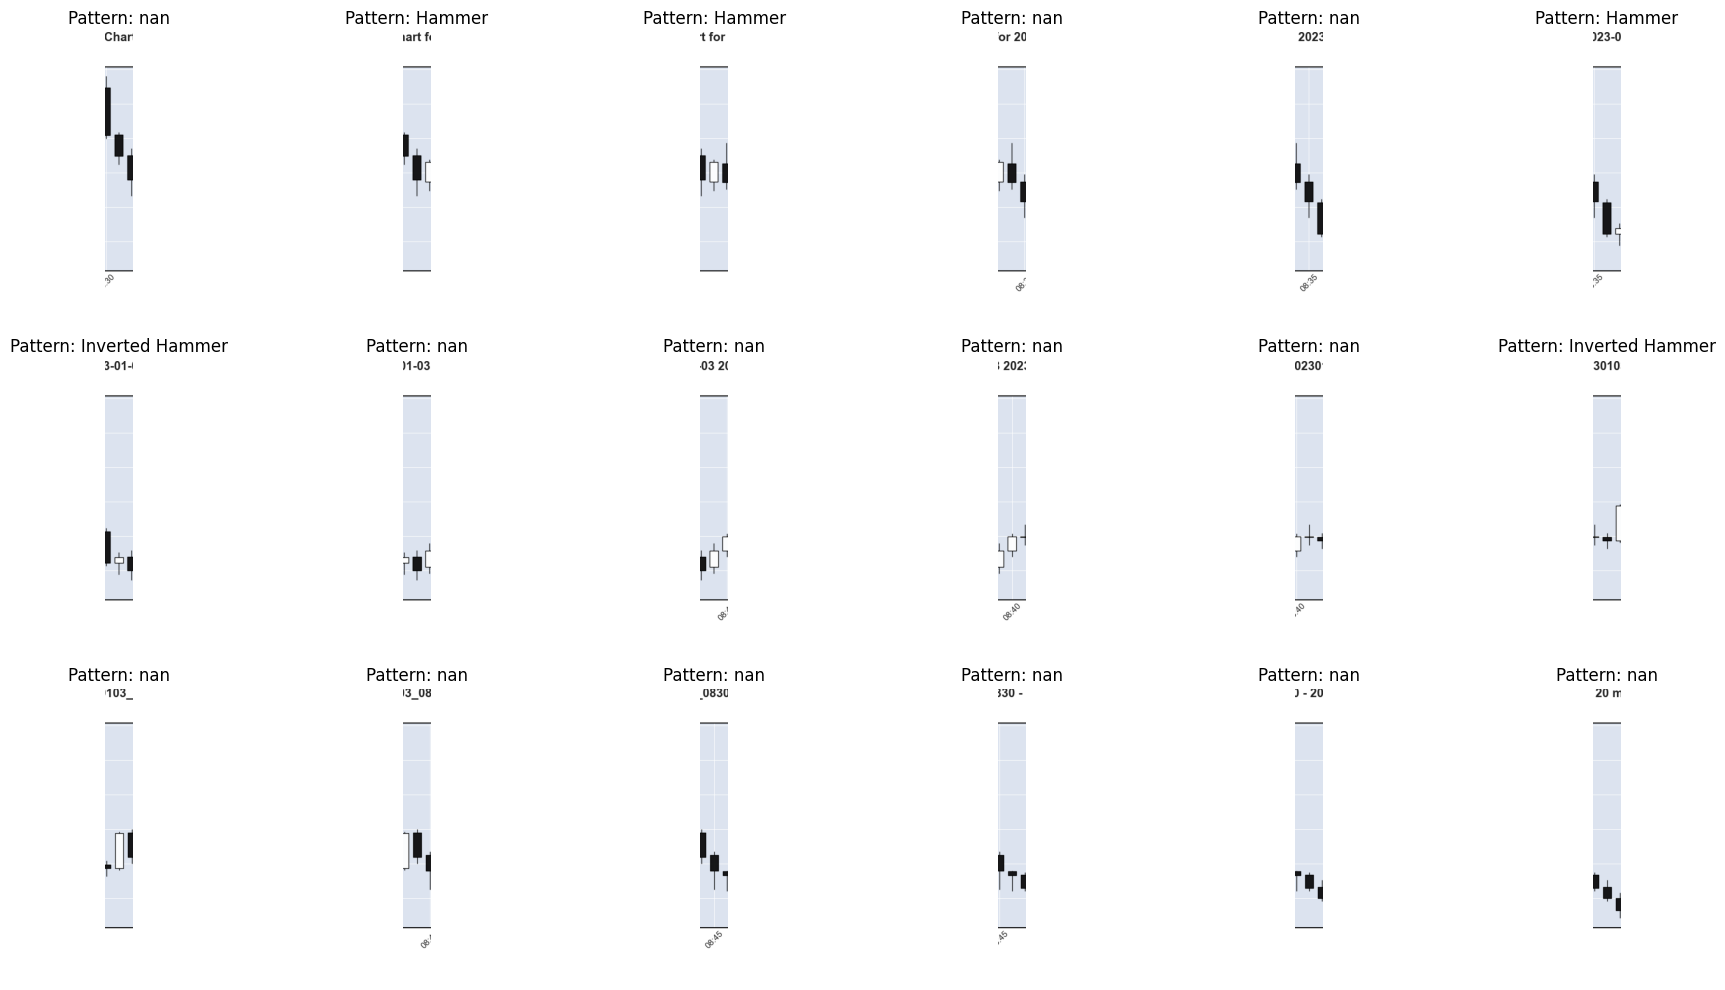

In [26]:
'''
Testing to divide up images into individual candlestick patterns with desired info (previous candle, current candle, next candle).
'''

image_path = "D:\\codyb\\COMP6970_Final_Project_Data\\charts\\20_minute_intervals\\TSLA_Candlestick_20230103_0830_to_0850_Bearish.png"
image = cv2.imread(image_path)
image_height, image_width, _ = image.shape

csv_data = pd.read_csv(f"./labeling/{symbol}_minute_data_cleaned_labeled.csv")

x_start = 192
x_end = 677
total_width = x_end - x_start

window_width = 55
overlap_increment = 25

candlestick_images = []
candlestick_labels = []

for i in range(18):
    section_start = x_start + i * overlap_increment
    section_end = section_start + window_width

    if section_end > x_end:
        break
    
    candlestick_crop = image[:, section_start:section_end]
    candlestick_images.append(candlestick_crop)
    
    label_index = min(i, len(csv_data) - 1)
    candlestick_labels.append(csv_data["Candlestick Pattern"].iloc[label_index])

num_images = len(candlestick_images)
fig, axes = plt.subplots(3, 6, figsize=(20, 10))

for idx, ax in enumerate(axes.flat):
    if idx < num_images:
        crop_rgb = cv2.cvtColor(candlestick_images[idx], cv2.COLOR_BGR2RGB)
        ax.imshow(crop_rgb)
        ax.set_title(f"Pattern: {candlestick_labels[idx]}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

# Label Dataset without Nones

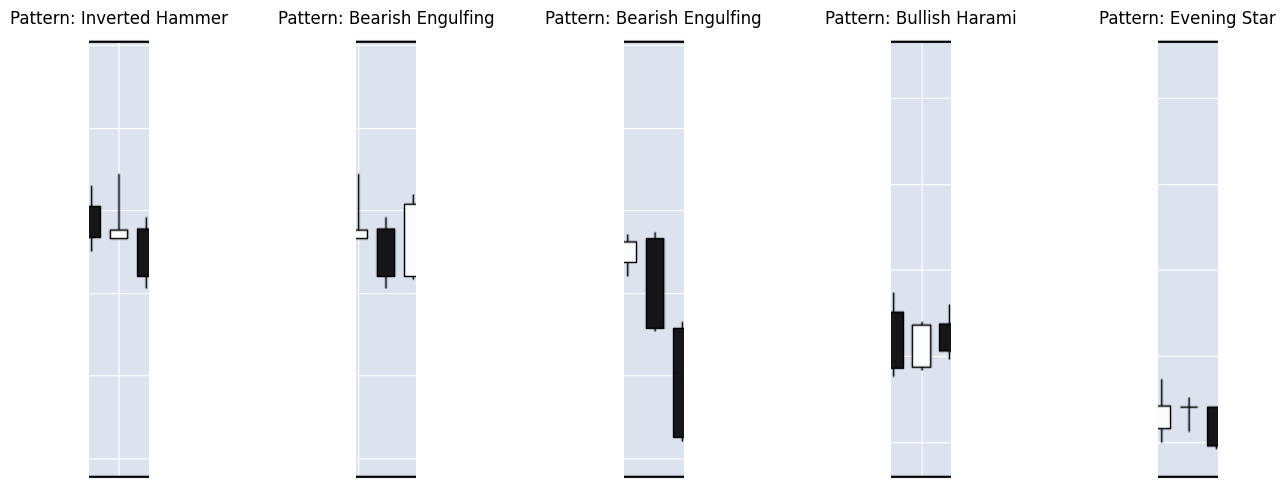

Unique labels: {'Bullish Engulfing', 'Bullish Harami', 'Hammer', 'Shooting Star', 'Inverted Hammer', 'Hanging Man', 'Evening Star', 'Morning Star', 'Bearish Engulfing'}
Number of unique labels: 9


In [41]:
'''
Dataset without the None labels. This is what the paper uses but you will not see something like this in the real world.
'''

image_dir = f'./labeling/20_minute_intervals'
csv_path = f"./labeling/{symbol}_minute_data_cleaned_labeled.csv"

csv_data = pd.read_csv(csv_path)
csv_data['datetime'] = pd.to_datetime(csv_data['datetime'])

x_start = 192
x_end = 677
total_width = x_end - x_start
window_width = 55
overlap_increment = 25

all_candlestick_images = []
all_candlestick_labels = []

for filename in os.listdir(image_dir):
    if filename.endswith(".png") and symbol in filename:
        parts = filename.split('_')
        date_str = parts[2]
        time_str = parts[3][:4]
        datetime_str = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]} {time_str[:2]}:{time_str[2:]}"
        start_datetime = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M")

        start_index = csv_data[csv_data['datetime'] == start_datetime].index
        if len(start_index) == 0:
            print(f"No matching datetime found in CSV for file {filename}")
            continue
        start_index = start_index[0]

        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)

        candlestick_images = []
        candlestick_labels = []
        for i in range(18):
            section_start = x_start + i * overlap_increment
            section_end = section_start + window_width

            if section_end > x_end:
                break

            candlestick_crop = image[60:475, section_start:section_end]
            candlestick_images.append(candlestick_crop)

            label_index = start_index + i + 1
            if label_index < len(csv_data):
                label = csv_data["Candlestick Pattern"].iloc[label_index]
                if pd.isna(label):
                    label = "None"
                candlestick_labels.append(label)

        all_candlestick_images.extend(candlestick_images)
        all_candlestick_labels.extend(candlestick_labels)

# Filter out "None" labels
filtered_images_labels = [
    (img, lbl) for img, lbl in zip(all_candlestick_images, all_candlestick_labels) if lbl != "None"
]
all_candlestick_images, all_candlestick_labels = zip(*filtered_images_labels)

num_images_to_display = 5
fig, axes = plt.subplots(1, min(num_images_to_display, len(all_candlestick_images)), figsize=(15, 5))

for idx in range(min(num_images_to_display, len(all_candlestick_images))):
    image_rgb = cv2.cvtColor(all_candlestick_images[idx], cv2.COLOR_BGR2RGB)
    axes[idx].imshow(image_rgb)
    axes[idx].set_title(f"Pattern: {all_candlestick_labels[idx]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

unique_labels = set(all_candlestick_labels)
print("Unique labels:", unique_labels)
print("Number of unique labels:", len(unique_labels))

# Label Dataset with Nones

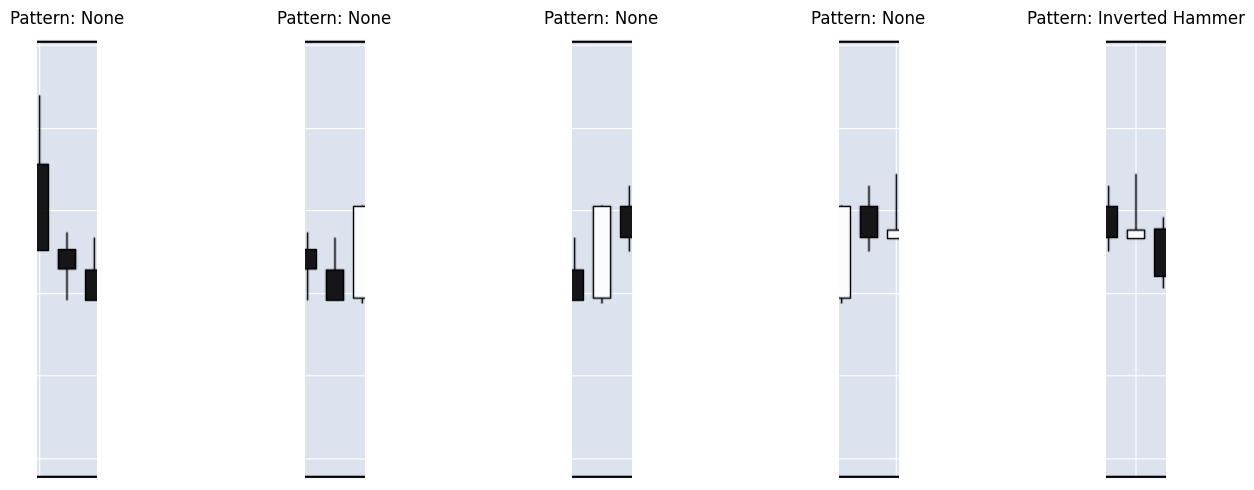

Unique labels: {'Bullish Engulfing', 'Bullish Harami', 'Hammer', 'Shooting Star', 'Inverted Hammer', 'Hanging Man', 'Evening Star', 'Morning Star', 'Bearish Engulfing', 'None'}
Number of unique labels: 10


In [54]:
'''
Full dataset with None labels included. This is what you will see in the real world.
'''

image_dir = f'./labeling/20_minute_intervals'
csv_path = f"./labeling/{symbol}_minute_data_cleaned_labeled.csv"

csv_data = pd.read_csv(csv_path)
csv_data['datetime'] = pd.to_datetime(csv_data['datetime'])

x_start = 192
x_end = 677
total_width = x_end - x_start
window_width = 55
overlap_increment = 25

all_candlestick_images = []
all_candlestick_labels = []

for filename in os.listdir(image_dir):
    if filename.endswith(".png") and symbol in filename:
        parts = filename.split('_')
        date_str = parts[2]
        time_str = parts[3][:4]
        datetime_str = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]} {time_str[:2]}:{time_str[2:]}"
        start_datetime = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M")

        start_index = csv_data[csv_data['datetime'] == start_datetime].index
        if len(start_index) == 0:
            print(f"No matching datetime found in CSV for file {filename}")
            continue
        start_index = start_index[0]

        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)

        candlestick_images = []
        candlestick_labels = []
        for i in range(18):
            section_start = x_start + i * overlap_increment
            section_end = section_start + window_width

            if section_end > x_end:
                break

            candlestick_crop = image[60:475, section_start:section_end]
            candlestick_images.append(candlestick_crop)

            label_index = start_index + i + 1
            if label_index < len(csv_data):
                label = csv_data["Candlestick Pattern"].iloc[label_index]
                if pd.isna(label):
                    label = "None"
                candlestick_labels.append(label)

        all_candlestick_images.extend(candlestick_images)
        all_candlestick_labels.extend(candlestick_labels)

num_images_to_display = 5
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for idx in range(num_images_to_display):
    image_rgb = cv2.cvtColor(all_candlestick_images[idx], cv2.COLOR_BGR2RGB)
    axes[idx].imshow(image_rgb)
    axes[idx].set_title(f"Pattern: {all_candlestick_labels[idx]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

unique_labels = set(all_candlestick_labels)
print("Unique labels:", unique_labels)
print("Number of unique labels:", len(unique_labels))

# Regular Implementation

In [48]:
'''
Dataset without GAF applied on images.
'''

class CandlestickDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert to PIL image if using transforms
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        
        return image, label

# GAF Implementation

In [55]:
'''
Dataset with GAF applied to images.
'''

class CandlestickDatasetWithGAF(Dataset):
    def __init__(self, images, labels, transform=None, image_size=(224, 224)):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.image_size = image_size
        self.gaf = GramianAngularField(image_size=self.image_size[0])  # Define GAF with desired output size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Resize image for GAF if needed
        image_resized = cv2.resize(image, (self.image_size[0], self.image_size[1]))
        
        # Normalize image data to range [0, 1] before GAF transformation
        image_resized = image_resized / 255.0

        # Convert the grayscale image data to GAF format
        image_gaf = self.gaf.fit_transform(image_resized.reshape(1, -1)).squeeze()
        
        # Ensure the GAF image has the correct dimensions for CNN input
        if image_gaf.ndim == 2:  # Single channel
            image_gaf = np.repeat(image_gaf[np.newaxis, :, :], 3, axis=0)  # Convert to 3 channels (C, H, W)

        # Convert to Tensor
        if self.transform:
            image_gaf = self.transform(image_gaf.transpose(1, 2, 0))  # Transpose to HWC for torchvision

        return image_gaf, label

In [56]:
'''
CNN that is not used in the paper because there were sizing issues because I am already shrinking the images significantly.
'''

class CandlestickCNN(nn.Module):
    def __init__(self, num_classes):
        super(CandlestickCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [57]:
'''
Encode the labels.
'''

label_encoder = LabelEncoder()
all_candlestick_labels_encoded = label_encoder.fit_transform(all_candlestick_labels)

label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

num_classes = len(label_encoder.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    all_candlestick_images, all_candlestick_labels_encoded, test_size=0.2, random_state=42
)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((56, 56)),
    transforms.ToTensor(),
])

Label Mapping:
Bearish Engulfing: 0
Bullish Engulfing: 1
Bullish Harami: 2
Evening Star: 3
Hammer: 4
Hanging Man: 5
Inverted Hammer: 6
Morning Star: 7
None: 8
Shooting Star: 9


# Regular Dataset

In [52]:
'''
Test/Train split for reulgar data.
'''

train_dataset = CandlestickDataset(X_train, y_train, transform=transform)
test_dataset = CandlestickDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# GAF Dataset

In [58]:
'''
Train/Test split for GAF data.
'''

train_dataset = CandlestickDatasetWithGAF(X_train, y_train, transform=transform)
test_dataset = CandlestickDatasetWithGAF(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Training Epoch 1/10:   0%|          | 0/180 [00:00<?, ?it/s]

Training Epoch 1/10: 100%|██████████| 180/180 [00:31<00:00,  5.79it/s]


Epoch [1/10], Loss: 0.8607


Training Epoch 2/10: 100%|██████████| 180/180 [00:30<00:00,  5.88it/s]


Epoch [2/10], Loss: 0.8282


Training Epoch 3/10: 100%|██████████| 180/180 [00:31<00:00,  5.79it/s]


Epoch [3/10], Loss: 0.8013


Training Epoch 4/10: 100%|██████████| 180/180 [00:31<00:00,  5.75it/s]


Epoch [4/10], Loss: 0.7761


Training Epoch 5/10: 100%|██████████| 180/180 [00:30<00:00,  5.82it/s]


Epoch [5/10], Loss: 0.7528


Training Epoch 6/10: 100%|██████████| 180/180 [00:31<00:00,  5.80it/s]


Epoch [6/10], Loss: 0.7240


Training Epoch 7/10: 100%|██████████| 180/180 [00:30<00:00,  5.87it/s]


Epoch [7/10], Loss: 0.7028


Training Epoch 8/10: 100%|██████████| 180/180 [00:30<00:00,  5.97it/s]


Epoch [8/10], Loss: 0.6705


Training Epoch 9/10: 100%|██████████| 180/180 [00:30<00:00,  5.95it/s]


Epoch [9/10], Loss: 0.6485


Training Epoch 10/10: 100%|██████████| 180/180 [00:30<00:00,  5.85it/s]


Epoch [10/10], Loss: 0.6243


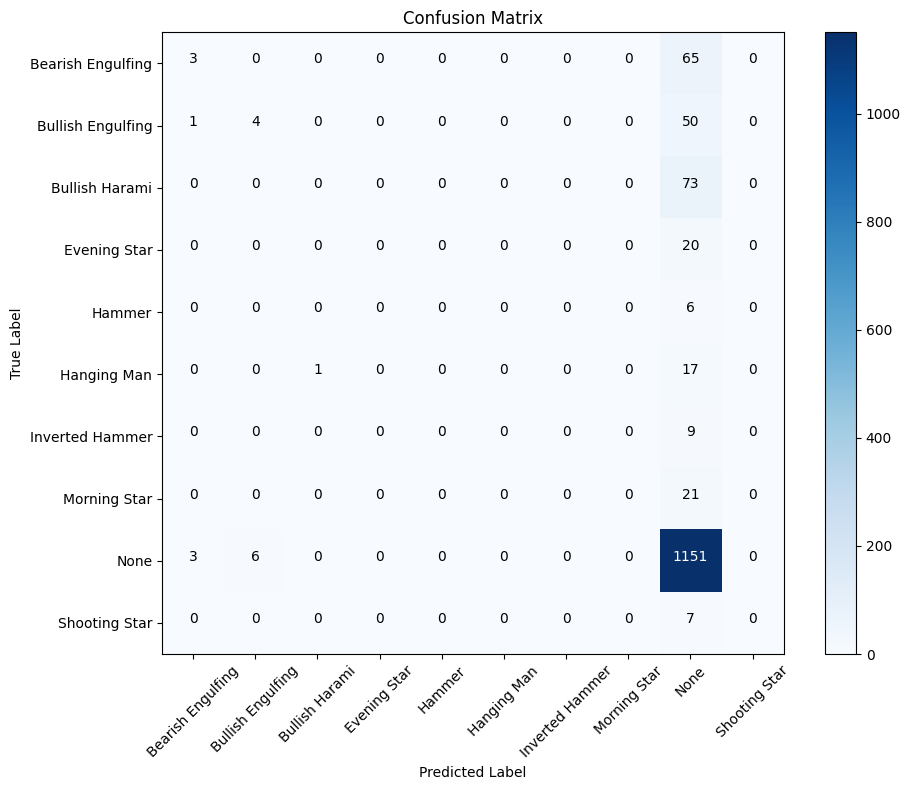

Test Accuracy: 80.58%


In [59]:
'''
Train model that is dependent on what cells you ran above.
'''

label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CandlestickCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)

class_names = [label_mapping[i] for i in range(num_classes)]

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.ylabel("True Label")
plt.xlabel("Predicted Label")

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.tight_layout()
plt.show()

accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Paper 2

In [60]:
class AdvancedDataset(Dataset):
    def __init__(self, file_path=None, daily_data=None, window_size=20, scaler=None):
        """
        Initializes the AdvancedDataset.

        Args:
            file_path (str, optional): Path to the CSV file containing the data.
            daily_data (list of pd.DataFrame, optional): Pre-split list of daily DataFrames.
            window_size (int, optional): The size of the window for state representation. Defaults to 20.
            scaler (StandardScaler, optional): A pre-fitted StandardScaler instance.
        """
        self.window_size = window_size
        self.scaler = scaler  # Assign the scaler

        if daily_data is not None:
            # Initialize with pre-split daily data
            self.daily_data = daily_data
            # If a scaler is provided, use it. Otherwise, raise an error
            if self.scaler is None:
                raise ValueError("Scaler must be provided when initializing with daily_data.")
        elif file_path is not None:
            # Load and preprocess the data from the CSV file
            self.data = pd.read_csv(file_path, parse_dates=["datetime"])

            # Ensure all required columns are present
            required_columns = [
                "datetime", "open", "high", "low", "close", "volume",
                "RSI_20", "Bollinger_High", "Bollinger_Low", "Bollinger_Middle",
                "OBV", "ATR_20", "Stochastic_%K", "Stochastic_%D",
                "VWAP", "SMA_7", "SMA_20", "EMA_7", "EMA_20"
            ]
            missing_columns = set(required_columns) - set(self.data.columns)
            if missing_columns:
                raise ValueError(f"Missing columns in the data: {missing_columns}")

            # Extract the date component
            self.data['date'] = self.data['datetime'].dt.date

            # Handle missing values using ffill and bfill to avoid FutureWarning
            self.data = self.data.ffill().bfill()

            # Group the data by date
            self.grouped = self.data.groupby('date')

            # Split data into days, ensuring each day has at least `window_size` entries
            self.daily_data = []
            for date, group in self.grouped:
                if len(group) >= self.window_size:
                    self.daily_data.append(group.reset_index(drop=True))
            
            # Initialize the scaler if not provided
            if self.scaler is None:
                # Exclude 'datetime' and 'date' from scaling
                feature_columns = [
                    "open", "high", "low", "close", "volume",
                    "RSI_20", "Bollinger_High", "Bollinger_Low", "Bollinger_Middle",
                    "OBV", "ATR_20", "Stochastic_%K", "Stochastic_%D",
                    "VWAP", "SMA_7", "SMA_20", "EMA_7", "EMA_20"
                ]
                self.scaler = StandardScaler()
                self.scaler.fit(self.data[feature_columns].values)

        else:
            raise ValueError("Either 'file_path' or 'daily_data' must be provided.")

    def __len__(self):
        return len(self.daily_data)

    def __getitem__(self, idx):
        """
        Retrieves the item at the given index or slice.

        Args:
            idx (int or slice): The index or slice to retrieve.

        Returns:
            dict or AdvancedDataset: If idx is an int, returns a dictionary with processed data.
                                      If idx is a slice, returns a new AdvancedDataset instance.
        """
        if isinstance(idx, slice):
            # Handle slicing by returning a new AdvancedDataset instance with sliced daily_data and the same scaler
            sliced_data = self.daily_data[idx]
            return AdvancedDataset(daily_data=sliced_data, window_size=self.window_size, scaler=self.scaler)
        elif isinstance(idx, int):
            # Handle single index access
            day_data = self.daily_data[idx]

            # Select all 18 numerical features (excluding 'datetime' and 'date')
            feature_columns = [
                "open", "high", "low", "close", "volume",
                "RSI_20", "Bollinger_High", "Bollinger_Low", "Bollinger_Middle",
                "OBV", "ATR_20", "Stochastic_%K", "Stochastic_%D",
                "VWAP", "SMA_7", "SMA_20", "EMA_7", "EMA_20"
            ]
            raw_data = day_data[feature_columns].values  # Shape: [num_entries, 18]

            # Normalize the data
            normalized_data = self._normalize(raw_data)  # Shape: [num_entries, 18]

            states = []
            for i in range(len(normalized_data) - self.window_size + 1):
                state = normalized_data[i : i + self.window_size]  # Shape: [window_size, 18]
                state_tensor = torch.tensor(state, dtype=torch.float32).transpose(0, 1)  # Shape: [18, window_size]
                state_tensor = state_tensor.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 18, window_size]
                states.append(state_tensor)
            
            return {
                'states': states,  # List of tensors, each of shape [1, 1, 18, window_size]
                'raw_data': raw_data,  # Raw numerical data
                'datetimes': day_data['datetime'].values[self.window_size - 1 :],
                'dates': day_data['date'].iloc[0]
            }
        else:
            raise TypeError("Invalid index type. Must be int or slice.")

    def _normalize(self, data):
        """
        Normalizes the data using standard scaling (zero mean, unit variance).

        Args:
            data (np.ndarray): The raw OHLCV and technical indicators data. Shape: [num_entries, 18]

        Returns:
            np.ndarray: The normalized data. Shape: [num_entries, 18]
        """
        # Apply standard scaling (zero mean, unit variance)
        return self.scaler.transform(data)

In [61]:
# Single Scale 1D Convolution

class SingleScale1D(nn.Module):
    def __init__(self, input_channels=18, output_channels=5, kernel_size=3):
        super(SingleScale1D, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        return x

In [62]:
# 3x3 2D Convolution

class ThreeByThreeConv2D(nn.Module):
    def __init__(self, input_channels=1, output_channels=2, kernel_size=3):
        super(ThreeByThreeConv2D, self).__init__()
        self.conv2d = nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv2d(x)
        x = self.relu(x)
        return x

In [63]:
# 5x5 2D Convolution

class FiveByFiveConv2D(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, kernel_size=5):
        super(FiveByFiveConv2D, self).__init__()
        self.conv2d = nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv2d(x)
        x = self.relu(x)
        return x

In [64]:
# Multi-scale Network

class MultiScaleNet(nn.Module):
    def __init__(self, height=18, width=20):
        super(MultiScaleNet, self).__init__()
        self.single_scale_1d = SingleScale1D(input_channels=18, output_channels=5, kernel_size=3)
        self.three_by_three = ThreeByThreeConv2D(input_channels=1, output_channels=2, kernel_size=3)
        self.five_by_five = FiveByFiveConv2D(input_channels=1, output_channels=1, kernel_size=5)
        self.height = height
        self.width = width

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
        # Assuming height=18 (features) and width=sequence_length
        x_1d = x.view(batch_size, self.height, self.width)  # [batch, 18, width]
        features_1d = self.single_scale_1d(x_1d)            # [batch, 5, width]

        # Aggregate along the time dimension
        features_1d = features_1d.mean(dim=2, keepdim=True)  # [batch, 5, 1]
        features_1d = features_1d.view(batch_size, 5, 1, 1) # [batch, 5, 1, 1]
        features_1d = F.interpolate(features_1d, size=(self.height, self.width), mode='bilinear', align_corners=False)  # [batch, 5, height, width]

        features_3x3 = self.three_by_three(x)               # [batch, 2, height, width]
        features_5x5 = self.five_by_five(x)                 # [batch, 1, height, width]

        combined_features = torch.cat((features_1d, features_3x3, features_5x5), dim=1)  # [batch, 8, height, width]
        
        return combined_features

In [65]:
# Efficient Channel Attention (ECA) Block

class ECABlock(nn.Module):
    def __init__(self, channels, gamma=2, b=1):
        super(ECABlock, self).__init__()
        t = int(abs((math.log(channels, 2) + b) / gamma))
        k = t if t % 2 else t + 1
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=(k - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)                             # [batch, channels, 1, 1]
        y = y.squeeze(-1).transpose(-1, -2)             # [batch, 1, channels]
        y = self.conv(y)                                 # [batch, 1, channels]
        y = self.sigmoid(y)                              # [batch, 1, channels]
        y = y.transpose(-1, -2).unsqueeze(-1)           # [batch, channels, 1]
        return x * y.expand_as(x)


In [66]:
# Backbone Network

class Backbone(nn.Module):
    def __init__(self, input_channels=8):
        super(Backbone, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.eca = ECABlock(64)

    def forward(self, x):
        x = self.conv1(x)     # [batch, 64, H, W]
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)   # [batch, 64, H/2, W/2]
        x = self.conv2(x)     # [batch, 64, H/2, W/2]
        x = self.bn2(x)
        x = F.relu(x)
        x = self.eca(x)       # [batch, 64, H/2, W/2]
        return x

In [67]:
# Combined Network with Backbone

class MSNetWithBackbone(nn.Module):
    def __init__(self):
        super(MSNetWithBackbone, self).__init__()
        self.multi_scale_net = MultiScaleNet()
        self.backbone = Backbone(input_channels=8)  # 5 + 2 + 1 from MultiScaleNet

    def forward(self, x):
        x = self.multi_scale_net(x)   # [batch, 8, H, W]
        x = self.backbone(x)         # [batch, 64, H/2, W/2]
        return x

In [68]:
# Final Network with Q-Value Output

class MSNetWithQValue(nn.Module):
    def __init__(self, num_actions=3):
        super(MSNetWithQValue, self).__init__()
        self.multi_scale_with_backbone = MSNetWithBackbone()

        self.conv_final = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        
        # Determine the size after convolution
        sample_input = torch.randn(1, 1, 18, 20)  # [batch, channels, height=18, width=20]
        sample_output = self.multi_scale_with_backbone(sample_input)
        sample_output = self.conv_final(sample_output)
        sample_output = F.relu(sample_output)
        feature_map_size = sample_output.view(-1).size(0)

        self.fc1 = nn.Linear(feature_map_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = self.multi_scale_with_backbone(x)  # [batch, 64, H/2, W/2]
        x = self.conv_final(x)                 # [batch, 64, H/2, W/2]
        x = F.relu(x)
        x = self.flatten(x)                    # [batch, 64 * (H/2) * (W/2)]
        x = self.relu(self.fc1(x))            # [batch, 128]
        x = self.fc2(x)                        # [batch, num_actions]
        return x

In [69]:
# Create MS-CNN and ensure the output shape is the correct size (3 Q values: 1 for each action)

model = MSNetWithQValue(num_actions=3)
test_input = torch.randn(1, 1, 18, 20)
output = model(test_input)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 3])


In [70]:
class ReplayBuffer:
    # Initialize buffer as a double ended queue
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    # Push a state, action, reward, next_state, done tuple on the buffer
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    # Randomly sample
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        state_batch = torch.cat(state, dim=0)
        next_state_batch = torch.cat(next_state, dim=0)
        return (
            state_batch,
            torch.tensor(action, dtype=torch.long),
            torch.tensor(reward, dtype=torch.float32),
            next_state_batch,
            torch.tensor(done, dtype=torch.float32),
        )

    # Override buffer's length method and return length
    def __len__(self):
        return len(self.buffer)

In [71]:
class DDQNAgent:
    def __init__(self, buffer_capacity, gamma=0.99, lr=1e-3, target_update_freq=100):
        self.actor = MSNetWithQValue()
        self.target = MSNetWithQValue()
        self.target.load_state_dict(self.actor.state_dict())
        self.target.eval()

        self.buffer = ReplayBuffer(buffer_capacity)
        self.optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.gamma = gamma
        self.target_update_freq = target_update_freq
        self.steps = 0
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995

        self.position = 'sold_out'

    # Select an action based on current state
    def select_action(self, state):
        # Exploration block. 
        # If bought in and told to hold or buy randomly, hold. 
        # If sold out and told to hold or sell randomly, sell.
        if random.random() < self.epsilon:
            random_action = random.randint(0,2)
            if self.position == 'bought_in':
                if random_action in [0, 1]:
                    return 0
                else:
                    return 2
            else:
                if random_action in [0, 2]:
                    return 0
                else:
                    return 1
        # Eploitation block.
        # Select action with highest Q value
        else:
            with torch.no_grad():
                q_values = self.actor(state)
                max_q, max_action = q_values.max(dim=1)
                max_action = max_action.item()
                
                if self.position == 'bought_in':
                    if max_action in [0, 1]:
                        return 0
                    else:
                        return 2
                else:
                    if max_action in [0, 2]:
                        return 0
                    else:
                        return 1

        return 0

    def train(self, batch_size):
        if len(self.buffer) < batch_size:
            return

        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.buffer.sample(batch_size)

        with torch.no_grad():
            next_q_values = self.actor(next_state_batch)
            next_actions = next_q_values.argmax(dim=1)
            target_q_values = self.target(next_state_batch)
            target_q = reward_batch + self.gamma * (1 - done_batch) * target_q_values[range(batch_size), next_actions]

        current_q = self.actor(state_batch)[range(batch_size), action_batch]

        loss = F.mse_loss(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps % self.target_update_freq == 0:
            self.target.load_state_dict(self.actor.state_dict())

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.steps += 1

    def store_transition(self, state, action, reward, next_state, done):
        self.buffer.push(state, action, reward, next_state, done)

    def eval_mode(self):
        self.actor.eval()
        self.target.eval()
        self.epsilon = 0.0

In [72]:
class StockTradingEnvWithFeatures:
    def __init__(self, daily_dataset, k=5, testing=False):
        self.daily_dataset = daily_dataset
        self.current_day = 0
        self.num_days = len(daily_dataset)
        self.k = k
        self.testing = testing

        self.current_step = 0
        self.done = False
        self.price_history = []
        self.initial_cash = 500000
        self.cash_balance = self.initial_cash
        self.total_asset_value = self.cash_balance
        self.previous_total_asset_value = self.total_asset_value
        self.trade_log = []
        self.cost_basis = 0.0
        self.shares_held = 0

        self.reset()

    def reset(self):
        self.testing = False
        self.current_step = 0
        self.done = False
        self.price_history = []
        self.initial_cash = 500000
        self.cash_balance = self.initial_cash
        self.total_asset_value = self.cash_balance
        self.previous_total_asset_value = self.total_asset_value
        self.trade_log = []
        self.cost_basis = 0.0
        self.shares_held = 0

        if self.current_day >= self.num_days:
            self.done = True
            return None

        day_data = self.daily_dataset[self.current_day]
        self.states = day_data['states']
        self.raw_data = day_data['raw_data']
        self.datetimes = day_data['datetimes']
        self.window_size = self.states[0].shape[-1]
        self.num_steps = len(self.states)
        self.raw_close_prices = self.raw_data[self.window_size - 1 :, 3]

        self.current_day += 1

        return self._get_state()

    def _get_state(self):
        if self.current_step >= self.num_steps:
            self.done = True
            return None

        state = self.states[self.current_step]
        current_close_price = self.raw_data[self.current_step + self.window_size - 1, 3]
        self.price_history.append(current_close_price)
        return state

    def step(self, action):
        if self.current_step + 1 < self.num_steps:
            state = self.states[self.current_step]
            current_close_price = self.raw_close_prices[self.current_step]
            next_close_price = self.raw_close_prices[self.current_step + 1]
            datetime = self.datetimes[self.current_step]

            datetime = self.datetimes[self.current_step]

            profit = 0

            if action == 1:
                if current_close_price == 0:
                    num_shares = 0
                else:
                    num_shares = int(self.cash_balance / current_close_price)
                total_cost = num_shares * current_close_price
                self.cash_balance -= total_cost
                self.shares_held += num_shares
                self.cost_basis += total_cost

            elif action == 2:
                num_shares = self.shares_held
                total_proceeds = num_shares * current_close_price
                self.cash_balance += total_proceeds
                self.shares_held = 0
                profit = total_proceeds - self.cost_basis
                self.cost_basis = 0
            
            else:
                profit = 0.0

            self.previous_total_asset_value = self.total_asset_value
            self.total_asset_value = self.cash_balance + self.shares_held * current_close_price

            profit = self.total_asset_value - self.previous_total_asset_value

            if self.testing:
                reward = 0
            else:
                reward = self.calculate_reward(action, current_close_price)

            action_mapping = {0: 'Hold', 1: 'Buy', 2: 'Sell'}
            trade_info = {
                'datetime': datetime,
                'action': action_mapping[action],
                'reward': reward,
                'profit': profit,
                'total_asset_value': self.total_asset_value,
                'cash_balance': self.cash_balance,
                'shares_held': self.shares_held,
                'position': 'bought_in' if self.shares_held > 0 else 'sold_out'
            }
            self.trade_log.append(trade_info)

            self.current_step += 1
            done = self.current_step >= self.num_steps - 1
            return self._get_state(), reward, done, {}
        else:
            self.done = True
            return None, 0, True, {}

    def calculate_reward(self, action, current_close_price):
        POS_t = 1 if self.shares_held > 0 else 0

        R_k_t = []
        for i in range(1, self.k + 1):
            future_step = self.current_step + i
            if future_step >= self.num_steps:
                break
            future_price = self.raw_close_prices[future_step]
            if current_close_price == 0:
                R_k_t_i = 0
            else:
                R_k_t_i = (future_price - current_close_price) / current_close_price
            R_k_t.append(R_k_t_i)

        if len(R_k_t) < 2:
            SR_t = 0
        else:
            mean_R = np.mean(R_k_t)
            std_R = np.std(R_k_t)
            if std_R == 0:
                SR_t = 0
            else:
                SR_t = mean_R / std_R

        SSR_t = POS_t * SR_t

        return SSR_t

In [ ]:
file_path = "./labeling/SPXL_minute_data_cleaned_advanced.csv"
dataset = AdvancedDataset(file_path)
num_days = len(dataset)

train_size = int(0.8 * num_days)
test_size = num_days - train_size

train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]

print(f"Training Days: {len(train_dataset)}")
print(f"Testing Days: {len(test_dataset)}")

env_train = StockTradingEnvWithFeatures(train_dataset)
env_test = StockTradingEnvWithFeatures(test_dataset, testing=True)

# Initialize agent
agent = DDQNAgent(buffer_capacity=10000)
batch_size = 32

train_log_dir = "./training_logs/"
test_log_dir = "./testing_logs/"
os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

Training Days: 369
Testing Days: 93


In [101]:
'''
Training Loop
'''
for day in range(len(train_dataset)):
    state = env_train.reset()
    done = False
    total_reward = 0

    while not done and state is not None:
        action = agent.select_action(state)

        next_state, reward, done, _ = env_train.step(action)

        agent.store_transition(state, action, reward, next_state, done)

        agent.train(batch_size)

        if action == 1:
            agent.position = 'bought_in'
        elif action == 2:
            agent.position = 'sold_out'

        state = next_state
        total_reward += reward

    if env_train.shares_held > 0:
        last_close_price = env_train.raw_data[env_train.current_step + env_train.window_size - 1, 3]
        total_proceeds = env_train.shares_held * last_close_price
        profit = total_proceeds - env_train.cost_basis
        env_train.cash_balance += total_proceeds
        env_train.shares_held = 0
        env_train.cost_basis = 0.0
        env_train.total_asset_value = env_train.cash_balance

        trade_info = {
            'datetime': env_train.datetimes[-1],
            'action': 'Sell (EOD)',
            'reward': 0.0,
            'profit': profit,
            'total_asset_value': env_train.total_asset_value,
            'cash_balance': env_train.cash_balance,
            'shares_held': env_train.shares_held,
            'position': 'sold_out'
        }
        env_train.trade_log.append(trade_info)

        agent.position = 'sold_out'

    total_profit = env_train.total_asset_value - env_train.initial_cash
    print(f"Training Day {day + 1}/{len(train_dataset)}, Total Reward: {total_reward:.2f}, Total Profit: {total_profit:.2f}")

    trade_log = env_train.trade_log
    trade_log_df = pd.DataFrame(trade_log)
    trade_log_df.to_csv(f"{train_log_dir}/2trade_log_day_{day + 1}.csv", index=False)

    env_train.trade_log = []

Training Day 1/369, Total Reward: 33.59, Total Profit: -9276.15
Training Day 2/369, Total Reward: -82.90, Total Profit: -11902.09
Training Day 3/369, Total Reward: 43.96, Total Profit: 1272.20
Training Day 4/369, Total Reward: 14.83, Total Profit: -8344.40
Training Day 5/369, Total Reward: 43.67, Total Profit: -1678.43
Training Day 6/369, Total Reward: 32.84, Total Profit: 5847.99
Training Day 7/369, Total Reward: 109.12, Total Profit: 27260.40
Training Day 8/369, Total Reward: 92.93, Total Profit: 13183.66
Training Day 9/369, Total Reward: 2.79, Total Profit: -4211.65
Training Day 10/369, Total Reward: -95.72, Total Profit: -15613.74
Training Day 11/369, Total Reward: -52.18, Total Profit: 8147.29
Training Day 12/369, Total Reward: 82.66, Total Profit: 14572.01
Training Day 13/369, Total Reward: 99.96, Total Profit: 18647.97
Training Day 14/369, Total Reward: 35.88, Total Profit: 16470.40
Training Day 15/369, Total Reward: 34.20, Total Profit: 3738.05
Training Day 16/369, Total Reward

In [ ]:
'''
Testing Loop
'''

#Save Network weights for future use (training loops take 2 hours, so I needed this)
torch.save(agent.actor.state_dict(), './Model Weights/FinalActorSPXL.pth')
torch.save(agent.target.state_dict(), './Model Weights/FinalTargetSPXL.pth')
print("Agent's actor and target networks have been saved successfully.")

# Load Networks to perform testing and set agents to evaluation mode.
loaded_agent = DDQNAgent(buffer_capacity=10000)
loaded_agent.actor.load_state_dict(torch.load('./Model Weights/FinalActorSPXL.pth', weights_only=True))
loaded_agent.target.load_state_dict(torch.load('./Model Weights/FinalTargetSPXL.pth', weights_only=True))
loaded_agent.eval_mode()

print("Agent's actor and target networks have been loaded and set to evaluation mode successfully.")

for day in range(len(test_dataset)):
    state = env_test.reset()
    done = False
    total_reward = 0

    # While not at EOD or a random unforeseen error occurs, keep training
    while not done and state is not None:
        action = loaded_agent.select_action(state)

        next_state, reward, done, _ = env_test.step(action)

        if action == 1:
            agent.position = 'bought_in'
        elif action == 2:
            agent.position = 'sold_out'

        state = next_state
        total_reward += reward

    # Sell at EOD and log
    if env_test.shares_held > 0:
        last_close_price = env_test.raw_data[env_test.current_step + env_test.window_size - 1, 3]
        total_proceeds = env_test.shares_held * last_close_price
        profit = total_proceeds - env_test.cost_basis
        env_test.cash_balance += total_proceeds
        env_test.shares_held = 0
        env_test.cost_basis = 0.0
        env_test.total_asset_value = env_test.cash_balance

        trade_info = {
            'datetime': env_test.datetimes[-1],
            'action': 'Sell (EOD)',
            'reward': 0.0,
            'profit': profit,
            'total_asset_value': env_test.total_asset_value,
            'cash_balance': env_test.cash_balance,
            'shares_held': env_test.shares_held,
            'position': 'sold_out'
        }
        env_test.trade_log.append(trade_info)

        agent.position = 'sold_out'

    # Calculate Profit for Output
    total_profit = env_test.total_asset_value - env_test.initial_cash
    print(f"Testing Day {day + 1}/{len(test_dataset)}, Total Reward: {total_reward:.2f}, Total Profit: {total_profit:.2f}")

    # Log
    trade_log = env_test.trade_log
    trade_log_df = pd.DataFrame(trade_log)
    trade_log_df.to_csv(f"{test_log_dir}/2trade_log_day_{day + 1}.csv", index=False)

    # Empty for next loop
    env_test.trade_log = []

Agent's actor and target networks have been loaded and set to evaluation mode successfully.
Testing Day 1/93, Total Reward: 70.22, Total Profit: 10442.40
Testing Day 2/93, Total Reward: 50.48, Total Profit: 3458.82
Testing Day 3/93, Total Reward: 62.71, Total Profit: 5313.54
Testing Day 4/93, Total Reward: -4.62, Total Profit: -8084.90
Testing Day 5/93, Total Reward: 39.35, Total Profit: 6272.85
Testing Day 6/93, Total Reward: 167.74, Total Profit: 12475.68
Testing Day 7/93, Total Reward: 136.83, Total Profit: 11252.58
Testing Day 8/93, Total Reward: 183.33, Total Profit: 10931.80
Testing Day 9/93, Total Reward: 113.89, Total Profit: 2383.29
Testing Day 10/93, Total Reward: 42.60, Total Profit: -3075.81
Testing Day 11/93, Total Reward: 144.08, Total Profit: 10706.70
Testing Day 12/93, Total Reward: -153.89, Total Profit: -34416.14
Testing Day 13/93, Total Reward: 121.74, Total Profit: 7421.02
Testing Day 14/93, Total Reward: 66.42, Total Profit: -920.55
Testing Day 15/93, Total Reward: